# Exploratory Data Analysis of Chat Feedback and OTP Data

This notebook performs a **comprehensive exploratory data analysis (EDA)** on two datasets from the MIVA AI database:

- **`chat_feedback`** — captures user ratings, comments, and interaction logs, providing insights into satisfaction, sentiment, and engagement with chat services.
- **`otps`** — stores one-time password (OTP) authentication records, enabling analysis of verification success rates, request patterns, and system reliability.

The analysis covers:
- Data structure, schema, and missing values  
- Descriptive statistics for numerical and categorical variables  
- Distribution plots and correlation heatmaps  
- Outlier detection and time-series trends  
- Domain-specific insights (feedback sentiment, OTP usage patterns)

The goal is to uncover **actionable insights** about both **user experience** and **system authentication behavior**, forming a foundation for future predictive modeling, anomaly detection, and dashboard reporting.


In [ ]:
# Install psycopg2
!pip install psycopg2-binary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 23.6 MB/s eta 0:00:00


In [32]:
#Import the neccesary libraries
import pandas as pd
import psycopg2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Connection details
db_config = {
    "host": "16.170.143.253",
    "port": 5432,
    "user": "admin",
    "password": "password123",
    "database": "miva_ai_db"
}

try:
    # Connect to the PostgreSQL database
    conn = psycopg2.connect(**db_config)
    print("✅ Connected to the database successfully")

    # Create a cursor to interact with the DB
    cursor = conn.cursor()

    # Run a simple query
    cursor.execute("SELECT version();")
    version = cursor.fetchone()
    print("PostgreSQL version:", version)

    # Clean up
    cursor.close()
    conn.close()
    print("🔌 Connection closed")

except Exception as e:
    print("❌ Error:", e)


✅ Connected to the database successfully
PostgreSQL version: ('PostgreSQL 15.14 on x86_64-pc-linux-musl, compiled by gcc (Alpine 14.2.0) 14.2.0, 64-bit',)
🔌 Connection closed


**1. List all tables in the database**

*   List chat_feedback
*   List otps



Query the information_schema.tables:

In [13]:
db_config = {
    "host": "16.170.143.253",
    "port": 5432,
    "user": "admin",
    "password": "password123",
    "database": "miva_ai_db"
}

def run_query(query):
    conn = psycopg2.connect(**db_config)
    cursor = conn.cursor()
    cursor.execute(query)
    rows = cursor.fetchall()
    cursor.close()
    conn.close()
    return rows

# List tables
tables = run_query("""
    SELECT table_name
    FROM information_schema.tables
    WHERE table_schema = 'public'
    ORDER BY table_name;
""")

print("📂 Tables in the database:")
for t in tables:
    print("-", t[0])


📂 Tables in the database:
- chat_feedback
- otps


**1. Check columns in the chat_feedback table**

In [14]:
columns_chat_feedback = run_query("""
    SELECT column_name, data_type
    FROM information_schema.columns
    WHERE table_name = 'chat_feedback';
""")

print("📑 Columns in chat_feedback:")
for c in columns_chat_feedback:
    print("-", c[0], ":", c[1])


📑 Columns in chat_feedback:
- id : integer
- session_id : character varying
- user_id : character varying
- message_id : character varying
- feedback_type : character varying
- comment : text
- rating : integer
- widget_id : character varying
- user_agent : character varying
- ip_address : character varying
- created_at : timestamp with time zone
- updated_at : timestamp with time zone
- email : character varying


**2. Check columns in the otps table**

In [15]:
columns_otps = run_query("""
    SELECT column_name, data_type
    FROM information_schema.columns
    WHERE table_name = 'otps';
""")

print("📑 Columns in otps:")
for c in columns_otps:
    print("-", c[0], ":", c[1])


📑 Columns in otps:
- id : integer
- user_id : character varying
- otp_code : character varying
- purpose : character varying
- is_used : boolean
- created_at : timestamp with time zone
- expires_at : timestamp with time zone


**3. Preview rows from each table**

In [24]:
db_config = {
    "host": "16.170.143.253",
    "port": 5432,
    "user": "admin",
    "password": "password123",
    "database": "miva_ai_db"
}

def query_df(query):
    """Run a SQL query and return result as Pandas DataFrame"""
    conn = psycopg2.connect(**db_config)
    df = pd.read_sql(query, conn)
    conn.close()
    return df

In [41]:
# Load tables (LIMIT or WHERE as needed if very large)
df_chat = query_df("SELECT * FROM chat_feedback;")
df_otps = query_df("SELECT * FROM otps;")

print("chat_feedback shape:", df_chat.shape)
print("otps shape:", df_otps.shape)

# (Optional) try to auto-parse likely datetime columns
def try_parse_datetimes(df):
    for col in df.columns:
        if df[col].dtype == "object" and any(k in col.lower() for k in ["time","date","at","created","updated"]):
            try:
                df[col] = pd.to_datetime(df[col], errors="ignore", utc=True)
            except Exception:
                pass
    return df

df_chat = try_parse_datetimes(df_chat)
df_otps  = try_parse_datetimes(df_otps)


/tmp/ipython-input-1679261534.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/tmp/ipython-input-1679261534.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


chat_feedback shape: (11, 13)
otps shape: (0, 7)


/tmp/ipython-input-1060401351.py:13: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_datetime(df[col], errors="ignore", utc=True)
/tmp/ipython-input-1060401351.py:13: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_datetime(df[col], errors="ignore", utc=True)


**Missing Values Bar chart**

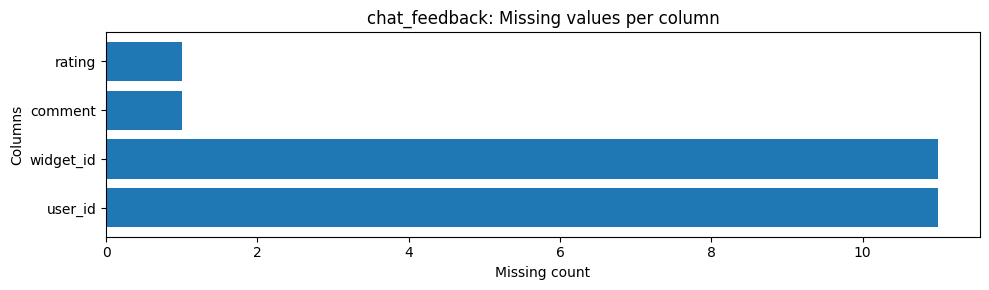

No missing values in otps.


In [42]:
def plot_missingness(df, title):
    na_counts = df.isna().sum()
    na_counts = na_counts[na_counts > 0].sort_values(ascending=False)
    if na_counts.empty:
        print(f"No missing values in {title}.")
        return
    plt.figure(figsize=(10, max(3, 0.35*len(na_counts))))
    plt.barh(na_counts.index.astype(str), na_counts.values)
    plt.xlabel("Missing count")
    plt.ylabel("Columns")
    plt.title(f"{title}: Missing values per column")
    plt.tight_layout()
    plt.show()

plot_missingness(df_chat, "chat_feedback")
plot_missingness(df_otps,  "otps")


In [44]:
df_chat.head()

,id,session_id,user_id,message_id,feedback_type,comment,rating,widget_id,user_agent,ip_address,created_at,updated_at,email
0,1,c4d9f7cc-f457-47a9-8b8c-25271af8bea2,None,lu4tkim5y,thumbs_up,This is such a great feedback,5.0,None,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,105.113.107.176,2025-09-10 21:25:47.159093+00:00,2025-09-10 21:25:47.159093+00:00,unknown@example.com
1,2,778215eb-1bd5-4554-a6e7-75d924efda07_175758928...,None,6em62q51h,thumbs_up,None,5.0,None,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,105.117.8.108,2025-09-11 12:39:59.617006+00:00,2025-09-11 12:39:59.617006+00:00,unknown@example.com
2,3,63d70bdf-5a3b-42f0-9cb8-422e645a6fb1_175795118...,None,585xext24,thumbs_up,This is a great feedback,5.0,None,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,105.113.107.176,2025-09-15 15:56:30.270865+00:00,2025-09-15 15:56:30.270865+00:00,unknown@example.com
3,4,test-session-123,None,test-message-456,thumbs_up,Great response!,5.0,None,curl/8.7.1,127.0.0.1,2025-09-15 15:57:50.845652+00:00,2025-09-15 15:57:50.845652+00:00,test@example.com
4,5,bef47851-fd06-4165-8a74-ea9596135bc5_175795186...,None,nst0ezrz6,thumbs_down,"i asked ""Who's the chancellor of Miva Open Uni...",1.0,None,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,41.242.60.202,2025-09-15 15:58:47.524775+00:00,2025-09-15 15:58:47.524775+00:00,unknown@example.com


**2. Numeric distributions — histograms (one figure per numeric column)**

In [47]:
import matplotlib.pyplot as plt
import numpy as np

def plot_numeric_histograms(df, title):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not num_cols:
        print(f"No numeric columns in {title}.")
        return

    for col in num_cols:
        plt.figure(figsize=(6,4))
        data = df[col].dropna().values
        if data.size == 0:
            continue

        # 5 bins
        plt.hist(data, bins=5, edgecolor="black")
        plt.title(f"{title}: Histogram of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()


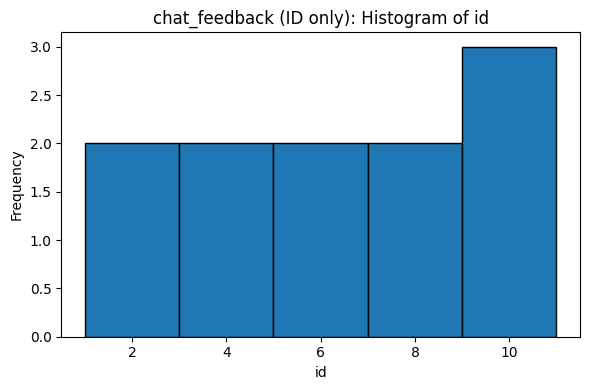

In [51]:

# Example usage:
plot_numeric_histograms(df_chat[['id']], "chat_feedback (ID only)")


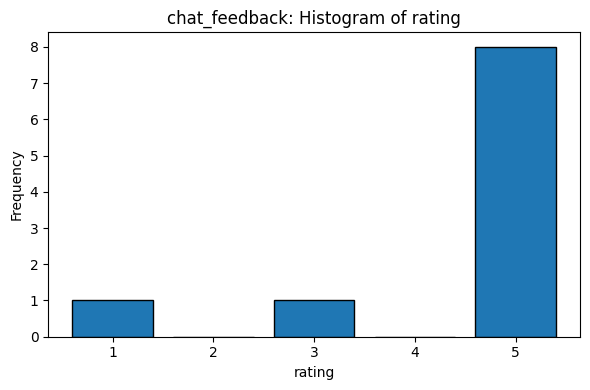

In [55]:
def plot_rating_histogram(df, col, title):
    data = df[col].dropna().values
    if data.size == 0:
        print(f"No data in {col}")
        return

    plt.figure(figsize=(6,4))

    # Explicit 5 bins aligned with 1–5 ratings
    plt.hist(data, bins=np.arange(0.5, 6.5, 1), edgecolor="black", rwidth=0.8)

    plt.title(f"{title}: Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.xticks([1, 2, 3, 4, 5])   # Force x-axis ticks to 1–5 only
    plt.tight_layout()
    plt.show()

# Example usage (only for rating column)
plot_rating_histogram(df_chat, "rating", "chat_feedback")

/tmp/ipython-input-3120938691.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


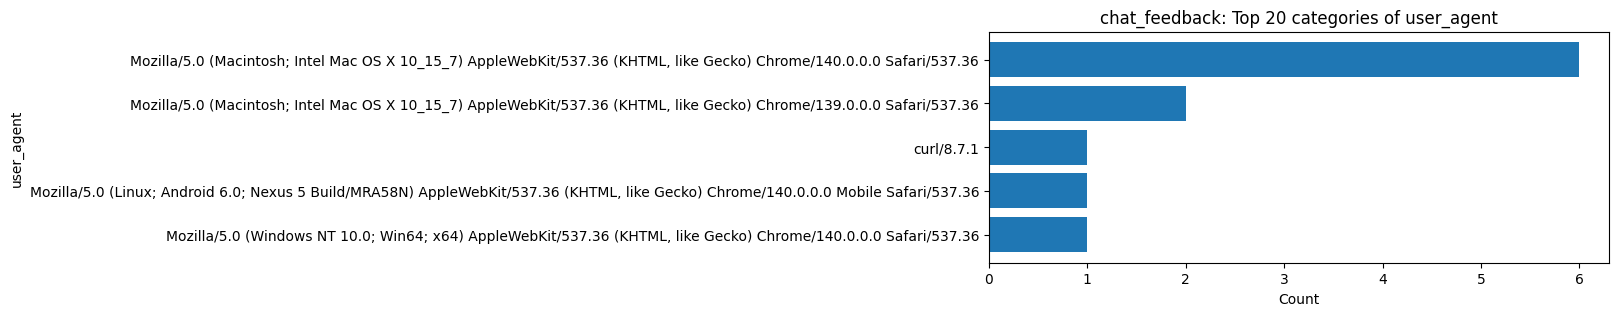

In [63]:
def plot_top_user_agent(df, title, top_n=20):
    if "user_agent" not in df.columns:
        print(f"'user_agent' column not found in {title}.")
        return

    vc = df["user_agent"].astype("object").fillna("⟂(NaN)").value_counts().head(top_n)
    if vc.empty:
        print(f"No data in 'user_agent' for {title}.")
        return

    plt.figure(figsize=(8, max(3, 0.35*len(vc))))
    plt.barh(vc.index.astype(str), vc.values)
    plt.gca().invert_yaxis()
    plt.title(f"{title}: Top {top_n} categories of user_agent")
    plt.xlabel("Count")
    plt.ylabel("user_agent")
    plt.tight_layout()
    plt.show()

# Example usage
plot_top_user_agent(df_chat, "chat_feedback", top_n=20)


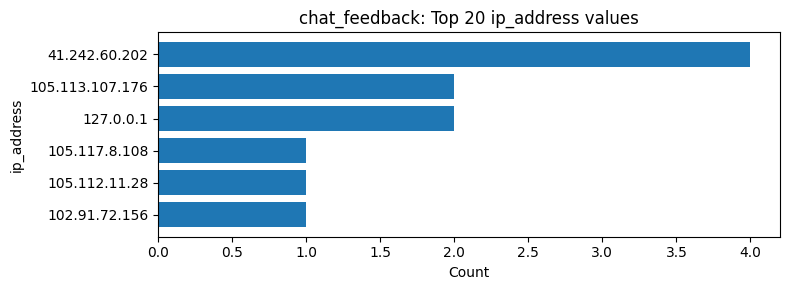

In [64]:
def plot_top_ip(df, title, col="ip_address", top_n=20):
    if col not in df.columns:
        print(f"Column {col} not found in {title}.")
        return

    vc = df[col].astype("object").fillna("⟂(NaN)").value_counts().head(top_n)
    if vc.empty:
        print(f"No data in {col} for {title}.")
        return

    plt.figure(figsize=(8, max(3, 0.35*len(vc))))
    plt.barh(vc.index.astype(str), vc.values)
    plt.gca().invert_yaxis()
    plt.title(f"{title}: Top {top_n} {col} values")
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

# Usage: only plot top 20 ip_address values in chat_feedback
plot_top_ip(df_chat, "chat_feedback", col="ip_address", top_n=20)


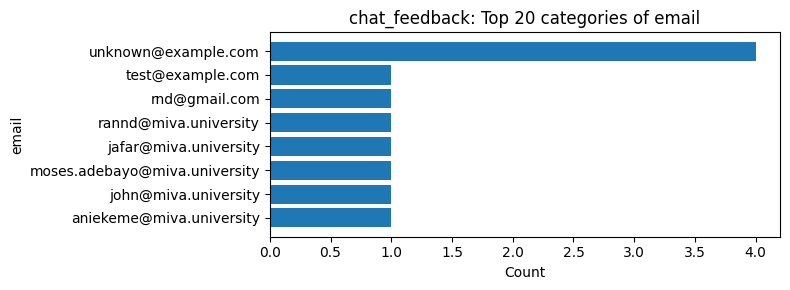

In [65]:
def plot_email_top_categories(df, title, top_n=20):
    if "email" not in df.columns:
        print(f"No 'email' column in {title}.")
        return

    vc = df["email"].astype("object").fillna("⟂(NaN)").value_counts().head(top_n)
    if vc.empty:
        print(f"No data in 'email' for {title}.")
        return

    plt.figure(figsize=(8, max(3, 0.35*len(vc))))
    plt.barh(vc.index.astype(str), vc.values)
    plt.gca().invert_yaxis()
    plt.title(f"{title}: Top {top_n} categories of email")
    plt.xlabel("Count")
    plt.ylabel("email")
    plt.tight_layout()
    plt.show()

# Usage
plot_email_top_categories(df_chat, "chat_feedback", top_n=20)


In [73]:
from pandas.api.types import is_datetime64_any_dtype

def plot_time_trends(df, title, freq="D"):
    # Detect datetime columns (handles tz-naive and tz-aware)
    time_cols = [c for c in df.columns if is_datetime64_any_dtype(df[c])]
    if not time_cols:
        print(f"No datetime columns detected in {title}.")
        return

    for col in time_cols:
        # Convert to datetime; make tz-aware (UTC) then strip tz to be safe
        s = pd.to_datetime(df[col], errors="coerce", utc=True).dropna()
        if s.empty:
            continue

        # Normalize to day (or any freq) and count
        # (tz_convert(None) makes them tz-naive for plotting)
        s = s.dt.tz_convert(None)
        stamped = s.dt.floor(freq)  # 'D' daily, 'H' hourly, etc.
        counts = stamped.value_counts().sort_index()

        if counts.empty:
            continue

        plt.figure(figsize=(10, 4))
        plt.plot(counts.index, counts.values)
        plt.title(f"{title}: Count by {col} ({freq})")
        plt.xlabel("Time")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()




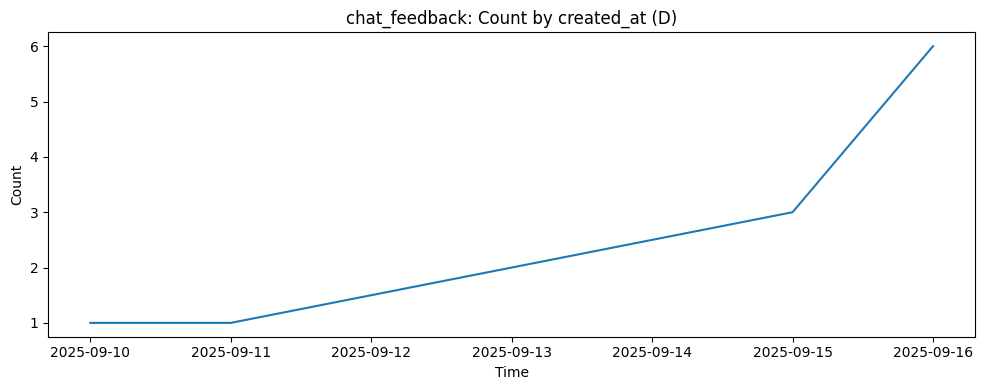

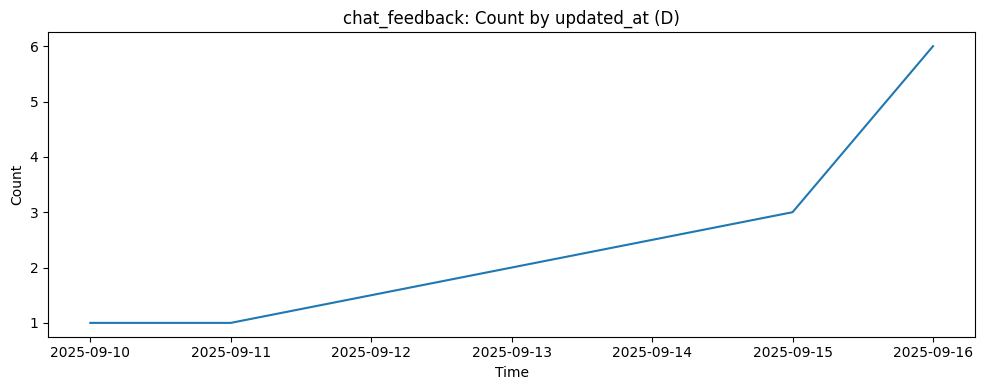

In [74]:
# Usage
plot_time_trends(df_chat, "chat_feedback")


In [75]:
plot_time_trends(df_otps,  "otps")

In [76]:
def eda_otps_special(df):
    title = "otps"
    # Heuristics for common columns
    code_col = next((c for c in df.columns if c.lower() in ["otp","code","otp_code"]), None)
    status_col = next((c for c in df.columns if c.lower() in ["status","state","used"]), None)

    # Length distribution of OTP
    if code_col is not None and df[code_col].notna().any():
        lengths = df[code_col].dropna().astype(str).str.len()
        if not lengths.empty:
            plt.figure(figsize=(6,4))
            plt.hist(lengths.values, bins=range(int(lengths.min()), int(lengths.max())+2))
            plt.title(f"{title}: Distribution of {code_col} length")
            plt.xlabel("Length")
            plt.ylabel("Frequency")
            plt.tight_layout()
            plt.show()
    else:
        print("No obvious OTP code column found for length analysis.")

    # Status / used distribution
    if status_col is not None:
        vc = df[status_col].astype("object").fillna("⟂(NaN)").value_counts()
        if not vc.empty:
            plt.figure(figsize=(8, max(3, 0.35*len(vc))))
            plt.barh(vc.index.astype(str), vc.values)
            plt.gca().invert_yaxis()
            plt.title(f"{title}: Distribution of {status_col}")
            plt.xlabel("Count")
            plt.ylabel(status_col)
            plt.tight_layout()
            plt.show()
    else:
        print("No obvious status/used column found for distribution chart.")

eda_otps_special(df_otps)


No obvious OTP code column found for length analysis.
No obvious status/used column found for distribution chart.


In [79]:
import matplotlib.pyplot as plt

def plot_text_length(df, col, title, min_len=3):
    """Plot text length histogram for a single text column."""
    if col not in df.columns:
        print(f"Column {col} not in {title}.")
        return

    if df[col].dtype != "object":
        print(f"Column {col} is not object dtype in {title}.")
        return

    # Compute lengths
    lengths = df[col].dropna().astype(str).str.len()
    if lengths.empty or lengths.median() < min_len:
        print(f"Column {col} skipped (not enough text-like data).")
        return

    plt.figure(figsize=(6,4))
    plt.hist(lengths.values, bins=30, edgecolor="black")
    plt.title(f"{title}: Text length distribution of {col}")
    plt.xlabel("Length (chars)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


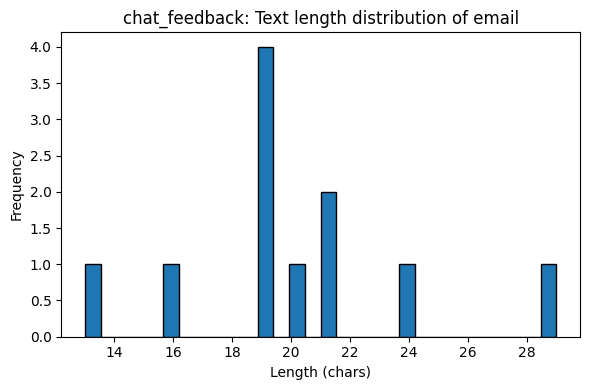

In [80]:
# chat_feedback
plot_text_length(df_chat, "email", "chat_feedback")



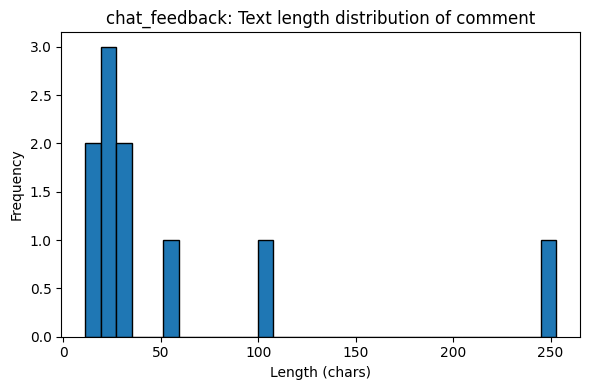

In [81]:
plot_text_length(df_chat, "comment", "chat_feedback")


In [85]:
# otps x created_at
plot_text_length(df_otps, "otp_code", "created_at", "expires_at")

Column otp_code skipped (not enough text-like data).


In [87]:
# Build OTP table
otp_table = df_otps[["otp_code", "created_at", "expires_at"]].copy()

# Ensure datetime format
otp_table["created_at"] = pd.to_datetime(otp_table["created_at"], errors="coerce")
otp_table["expires_at"] = pd.to_datetime(otp_table["expires_at"], errors="coerce")

# Calculate lifetime (in seconds and minutes)
otp_table["lifetime_sec"] = (otp_table["expires_at"] - otp_table["created_at"]).dt.total_seconds()
otp_table["lifetime_min"] = otp_table["lifetime_sec"] / 60

# Preview
otp_table.head(20)


,otp_code,created_at,expires_at,lifetime_sec,lifetime_min


In [83]:
df_otps.head()

,id,user_id,otp_code,purpose,is_used,created_at,expires_at


In [ ]:
# otps
plot_text_length(df_otps, "otp_code", "created_at")